In [1]:
# Import packages
import os
import sys
import warnings
import inspect
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.patches import Patch
from scipy.interpolate import make_interp_spline

# Set directories
notebook_dir = os.getcwd()
base_dir = os.path.join(notebook_dir, '..')
data_dir = os.path.join(base_dir, 'data', 'processed')
raw_data_dir = os.path.join(base_dir, 'data', 'raw')
src_dir = os.path.join(base_dir, 'src')
graph_dir = os.path.join(base_dir, 'results', 'graphs')
sys.path.append(src_dir)

# Ignore future warning
warnings.simplefilter(action='ignore', category=FutureWarning)

### 1. Calcualte risk factors returns

In [2]:
# function for creating factors
def create_factors(feature_path = 'credit_risk_', feature_name = "credit_factor", pct = 0.2):
    '''
    feature_path: first part of the csv file name
    feature_name: name of the feature column
    pct: percent quantile for high and low partition
    
    function returns data frame of features for all cycles
    '''
    
    for i in range(4):
        # read processed data files
        csv_string = feature_path + str(i + 1) + '.csv'
        feature_df = pd.read_csv(os.path.join(data_dir, csv_string))
        # drop empty columns
        feature_df = feature_df.loc[:, ~feature_df.columns.str.startswith('Unnamed')]
        price_string = 'price_' + str(i + 1) + '.csv'
        price_df = pd.read_csv(os.path.join(data_dir, price_string))
        # create year column
        temp_df = feature_df.copy()
        temp_df['Year'] = pd.DatetimeIndex(feature_df['Date']).year
        temp_price = price_df.copy()
        temp_price['Year'] = pd.DatetimeIndex(temp_price['Date']).year
        # average feature value by year
        yearly_feature = temp_df.groupby(['Year']).mean()
        yearly_feature = yearly_feature.transpose()
        unique_yrs = temp_df['Year'].unique()
        n_stocks = len(yearly_feature.index)
        n = int(n_stocks * pct)

        for idx, year in enumerate(unique_yrs):
            # stocks with lowest and highest feature values for the year
            low_stocks = yearly_feature.iloc[:, idx].sort_values().index.values[0:n]
            high_stocks = yearly_feature.iloc[:, idx].sort_values().index.values[(n_stocks - n):n_stocks]
            # stock prices of stocks with lowest feature value
            low_price = temp_price[temp_price['Year'] == year][np.append(low_stocks, "Date")]
            # stock prices of stocks with highest feature value
            high_price = temp_price[temp_price['Year'] == year][np.append(high_stocks, "Date")]

            if year != max(unique_yrs):
                # add stock prices of the "first day" of the next year for return calculation
                low_price = pd.concat( 
                    [
                        low_price, 
                        temp_price[temp_price['Year'] == (year + 1)][np.append(low_stocks, "Date")].head(1)
                    ]
                )

                # add stock prices of the "first day" of the next year for return calculation
                high_price = pd.concat( 
                    [
                        high_price, 
                        temp_price[temp_price['Year'] == (year + 1)][np.append(high_stocks, "Date")].head(1)
                    ]
                )
             # save date column
            temp_dates = low_price['Date'][1:]
            # calculate returns and take average across stocks (rows)
            temp_returns_low = low_price.drop(
                columns = ['Date']
            ).pct_change().iloc[1:, :].mean(axis = 1).to_frame(name = feature_name)
            # calculate returns and take average across stocks (rows)
            temp_returns_high = high_price.drop(
                columns = ['Date']
            ).pct_change().iloc[1:, :].mean(axis = 1).to_frame(name = feature_name)
            # return of high credit risk - return of low credit risk
            temp_returns = temp_returns_high.sub(temp_returns_low)
            temp_returns['Date'] = temp_dates
            if idx == 0:
                returns_df = temp_returns
            else:
                returns_df = pd.concat([returns_df, temp_returns])
        if i == 0:
            daily_returns = returns_df
        else:
            daily_returns = pd.concat([daily_returns, returns_df])
    return daily_returns

In [3]:
# percentile argument
pct = 0.2
# create credit factors
credit_factors = create_factors(feature_path = 'credit_risk_', feature_name = "credit_factor", pct = pct)
credit_factors = credit_factors.reset_index().drop(columns = ['index'])
# credit_factors.to_csv(os.path.join(data_dir, "credit_factor_daily.csv"))

# create turnover factors
turnover_factors = create_factors(feature_path = 'turnover_', feature_name = "turnover_factor", pct = pct)
turnover_factors = turnover_factors.reset_index().drop(columns = ['index'])
# turnover_factors.to_csv(os.path.join(data_dir, "turnover_factor_daily.csv"))

### 2. Handle data mismatch

If the feature data are not daily data, the code in part 1 may have some issue in handling the cut off points of data frames. The following code fix this problem.

In [4]:
def create_factors_sep(feature_df, price_df, pct=0.2):
    # Drop empty columns
    feature_df = feature_df.loc[:, ~feature_df.columns.str.startswith('Unnamed')]    
    # Create year column
    temp_df = feature_df.copy()
    temp_df['Year'] = pd.DatetimeIndex(feature_df['Date']).year
    temp_price = price_df.copy()
    temp_price['Year'] = pd.DatetimeIndex(temp_price['Date']).year
    # Average feature value by year
    yearly_feature = temp_df.groupby(['Year']).mean()
    yearly_feature = yearly_feature.transpose()
    # Unique years for feature and price
    unique_yrs_feature = temp_df['Year'].unique()
    unique_yrs_price = temp_price['Year'].unique()
    n_stocks = len(yearly_feature.index)
    n = int(n_stocks * pct)
    
    for i, year in enumerate(unique_yrs_price):
        # Mismatch between non-daily data and daily data
        if year in unique_yrs_feature:
            idx = i
        else:
            idx = i-1
        # Stocks with lowest and highest feature values for the year
        low_stocks = yearly_feature.iloc[:, idx].sort_values().index.values[0:n]
        high_stocks = yearly_feature.iloc[:, idx].sort_values().index.values[(n_stocks - n):n_stocks]
        # Stock prices of stocks with lowest feature value
        low_price = temp_price[temp_price['Year'] == year][np.append(low_stocks, "Date")]
        # Stock prices of stocks with highest feature value
        high_price = temp_price[temp_price['Year'] == year][np.append(high_stocks, "Date")]
        
        if year != max(unique_yrs_price):
            # Add stock prices of the "first day" of the next year for return calculation
            low_next_year = temp_price[temp_price['Year'] == (year+1)][np.append(low_stocks, "Date")].head(1)
            low_price = pd.concat([low_price, low_next_year])

            # Add stock prices of the "first day" of the next year for return calculation
            high_next_year = temp_price[temp_price['Year'] == (year+1)][np.append(low_stocks, "Date")].head(1)
            high_price = pd.concat([high_price, high_next_year])
            
        # Save date column
        temp_dates = low_price['Date'][1:]
        # Calculate returns and take average across stocks (rows)
        temp_returns_low = low_price.drop(columns = ['Date']).pct_change().iloc[1:, :].mean(axis=1).to_frame()
        # Calculate returns and take average across stocks (rows)
        temp_returns_high = high_price.drop(columns = ['Date']).pct_change().iloc[1:, :].mean(axis=1).to_frame()
        # Return of high credit risk - return of low credit risk
        temp_returns = temp_returns_high.sub(temp_returns_low)
        temp_returns['Date'] = temp_dates
        temp_returns.columns = ['feature_return', 'Date']
        temp_returns = temp_returns[['Date', 'feature_return']]
        
        # Concat the years
        if idx == 0:
            returns_df = temp_returns
        else:
            returns_df = pd.concat([returns_df, temp_returns])
    return returns_df

def create_factor_agg(feature_path, feature_name, pct):
    '''
    feature_path: first part of the csv file name
    feature_name: name of the feature column
    pct: percent quantile for high and low partition
    
    function returns data frame of features for all cycles
    '''
    # Price data are divided into 4 cycles
    for i in range(4):
        # Read processed data files
        csv_string = feature_path + str(i + 1) + '.csv'
        feature_df = pd.read_csv(os.path.join(data_dir, csv_string))        
        price_string = 'price_' + str(i + 1) + '.csv'
        price_df = pd.read_csv(os.path.join(data_dir, price_string))
        # Drop empty columns
        feature_df = feature_df.loc[:, ~feature_df.columns.str.startswith('Unnamed')]        
        # Calculate feture high-low return
        returns_df = create_factors_sep(feature_df, price_df, pct)
        if i == 0:
            daily_returns = returns_df
        else:
            daily_returns = pd.concat([daily_returns, returns_df])    
    
    # Drop duplicate dates
    daily_returns = daily_returns.drop_duplicates(subset='Date', keep='first')
    # Rename columns
    daily_returns.columns = ['Date', feature_name]
    # Convert data into return percentage
    daily_returns[feature_name] = daily_returns[feature_name] * 100
    return daily_returns

Use the function `create_factor_agg` to create cedit_risk and liquidity (turnover) factor

In [5]:
pct = 0.2
# Create credit risk factor
credit_factors2 = create_factor_agg(feature_path='credit_risk_', feature_name="credit_factor", pct=pct)
credit_factors2 = credit_factors2.reset_index().drop(columns = ['index'])

# create turnover factor
turnover_factors2 = create_factor_agg(feature_path='turnover_', feature_name="turnover_factor", pct=pct)
turnover_factors2 = turnover_factors2.reset_index().drop(columns = ['index'])

# combine two factors
ourfactor_daily = pd.merge(credit_factors2, turnover_factors2, on='Date')
# ourfactor_daily.to_csv(os.path.join(data_dir, "ourfactor_daily.csv"))

Check how many days in the stock price data are missing in ourfactor_daily. We can see that only the first day of the entire period is missing.

In [6]:
for i in range(4):
    price_string = 'price_' + str(i + 1) + '.csv'
    price_df = pd.read_csv(os.path.join(data_dir, price_string))    
    if i == 0:
        date_combined = price_df['Date']
    else:
        date_combined = pd.concat([date_combined, price_df['Date']]) 
    # Drop duplicate dates
    date_combined = date_combined.drop_duplicates(keep='first')

# Convert to datetime format and then to 'YYYY-MM-DD' string format
date_combined = pd.to_datetime(date_combined).dt.strftime('%Y-%m-%d')
set_ourfactor_dates = set(pd.to_datetime(ourfactor_daily['Date']).dt.strftime('%Y-%m-%d'))
set_date_list = set(date_combined)
# Find dates in date_combined not in ourfactor_daily['Date']
dates_not_in_ourfactor = list(set_date_list - set_ourfactor_dates)
print(dates_not_in_ourfactor, date_combined.shape, ourfactor_daily.shape)

['1990-10-10'] (8400,) (8399, 3)


### 3. Create weekly/monthly/annual feature return data using daily data

We will use the daily feature dataframe to calculate weekly, monthly, annual return. The return are all represented in percentage return.

In [7]:
# Calculate the compound weekly return (this is not entirely accurate)
def compound_returns(x):
    return (np.prod(1 + x) - 1) * 100

def weekly_returns(daily_df):
    daily_df['Date'] = pd.to_datetime(daily_df['Date'])
    daily_tmp = daily_df.copy()    
    # Create columns for week and year
    daily_tmp['Week'] = daily_df['Date'].dt.isocalendar().week  
    daily_tmp['Year'] = daily_df['Date'].dt.year 
    daily_tmp2 = daily_tmp.drop(columns=['Date'])
    # Convert returns to decimal
    daily_tmp2[daily_tmp2.columns.difference(['Year', 'Week'])] /= 100  
    weekly_df = daily_tmp2.groupby(['Year', 'Week']).apply(compound_returns).drop(columns=['Week', 'Year'])
    weekly_df = weekly_df.reset_index()

    # Add the last day of the week back to weekly_df
    last_day_of_week = daily_tmp.groupby(['Year', 'Week'])['Date'].max().reset_index()
    weekly_df = pd.merge(weekly_df, last_day_of_week, on=['Year', 'Week'], how='left')
    weekly_df = weekly_df.drop(columns=['Year', 'Week'])
    # Change column order
    columns_order = ['Date'] + [col for col in weekly_df.columns if col not in ['Date']]
    weekly_df = weekly_df[columns_order]
    return weekly_df

def monthly_returns(daily_df):
    daily_df['Date'] = pd.to_datetime(daily_df['Date'])
    daily_tmp = daily_df.copy()
    # Create column for year and month
    daily_tmp['Year_Month'] = daily_tmp['Date'].dt.to_period('M')
    daily_tmp = daily_tmp.drop(columns=['Date'])
    # Convert returns to decimal
    daily_tmp[daily_tmp.columns.difference(['Year_Month'])] /= 100  
    # Calculate monthly compound return
    monthly_df = daily_tmp.groupby(['Year_Month']).apply(compound_returns)
    return monthly_df.reset_index()

def yearly_returns(daily_df):
    daily_df['Date'] = pd.to_datetime(daily_df['Date'])
    daily_tmp = daily_df.copy()
    # Create column for year
    daily_tmp['Year'] = daily_tmp['Date'].dt.to_period('Y')
    daily_tmp = daily_tmp.drop(columns=['Date'])
    # Convert returns to decimal
    daily_tmp[daily_tmp.columns.difference(['Year'])] /= 100  
    # Calculate monthly compound return
    yearly_df = daily_tmp.groupby(['Year']).apply(compound_returns)
    return yearly_df.reset_index()


In [8]:
# Calculate weekly/monthly/annual return
ourfactor_weekly = weekly_returns(ourfactor_daily)
ourfactor_monthly = monthly_returns(ourfactor_daily)
ourfactor_yearly = yearly_returns(ourfactor_daily)

# Store them into csv
# ourfactor_weekly.to_csv(os.path.join(data_dir, "ourfactor_weekly.csv"))
# ourfactor_monthly.to_csv(os.path.join(data_dir, "ourfactor_monthly.csv"))
# ourfactor_yearly.to_csv(os.path.join(data_dir, "ourfactor_yearly.csv"))

# Create annual return for Kenny's feature for comparison
kc_daily = pd.merge(credit_factors, turnover_factors, on='Date')
kcfactor_yearly = yearly_returns(kc_daily)
kcfactor_yearly[['credit_factor','turnover_factor']] = kcfactor_yearly[['credit_factor','turnover_factor']]*100

### 4. Visualization

Make a plot to compare the difference between code in section 1 and section 2. From the graph we can see that the difference is significant on the points where the factor return have a lot of missing data using code in section 1.

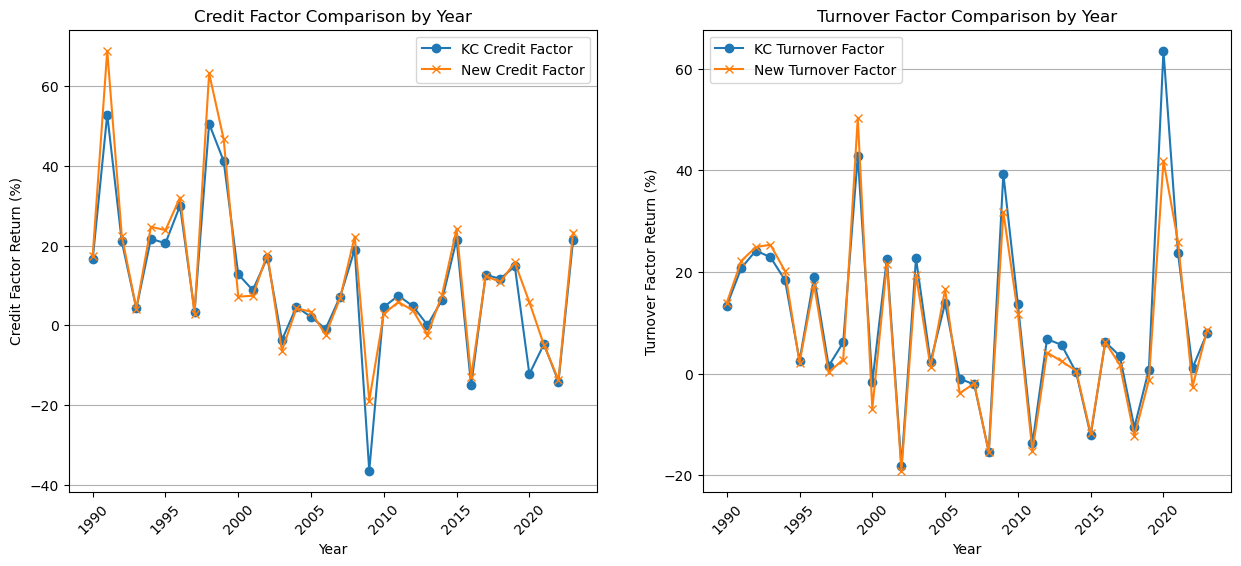

In [10]:
# Merge the two DataFrames on the 'Year' column for comparison
merged_df = pd.merge(kcfactor_yearly, ourfactor_yearly, on='Year', suffixes=('_kc', '_our'))
merged_df['Year'] = merged_df['Year'].astype(str)

# Plotting
ticks = merged_df['Year'].tolist()[::5]
plt.figure(figsize=(15, 6))

# Plot for credit_factor
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
plt.plot(merged_df['Year'], merged_df['credit_factor_kc'], label='KC Credit Factor', marker='o')
plt.plot(merged_df['Year'], merged_df['credit_factor_our'], label='New Credit Factor', marker='x')
plt.title('Credit Factor Comparison by Year')
plt.xlabel('Year')
plt.xticks(ticks, rotation=45)
plt.ylabel('Credit Factor Return (%)')
plt.legend()
plt.grid(True, axis='y')

# Plot for turnover_factor
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
plt.plot(merged_df['Year'], merged_df['turnover_factor_kc'], label='KC Turnover Factor', marker='o')
plt.plot(merged_df['Year'], merged_df['turnover_factor_our'], label='New Turnover Factor', marker='x')
plt.title('Turnover Factor Comparison by Year')
plt.xlabel('Year')
plt.xticks(ticks, rotation=45)
plt.ylabel('Turnover Factor Return (%)')
plt.legend()
plt.grid(True, axis='y')

# Adjust layout and show plot
plt.savefig(os.path.join(graph_dir, 'our_factors.png'))
plt.show()